# **Seasons of Library Checkouts**

The purpose of this notebook is to explore how the seasons and time of year impact how much people read. Do people read more when it’s cold and they are cooped up inside, or on summer vacation while they’re lounging by the pool? 

> My hypothesis is that people read more in the winter months when it is cold and dark outside. 


In my preliminary research I discovered that book sales data is hard to come by. I’ve decided to use the Seattle Public Library open data and base my research off of checkout figures and time of year. The dataset includes checkout data for each title starting in 2005:

https://data.seattle.gov/Community/Checkouts-by-Title/tmmm-ytt6 

The full dataset is over 34.5M records, so I will filter for 2018 checkouts of books categorized as fiction.

Here is the link to the CSV I created:

https://drive.google.com/file/d/1-OM6wro83N5u-aLo-K4jzJTz6tlW-fOP/view?usp=sharing

First I will retrieve the necessary data.

In [13]:
#this cell is not necessary to run; it will take forever 

#retrieve the data
import requests

data = []

#trying to figure out how many total records there are for 2018 by changing the range() number
#filtered for only fiction checkouts in 2018
for i in range(75):
  x = i*5000

  url = 'https://data.seattle.gov/resource/tmmm-ytt6.json?$where=starts_with(subjects,"Fiction")&$limit=5000&$offset='+str(x)+'&$order=:id'
  query = {'checkoutyear': '2018'}
  response = requests.get(url, params=query)
  
  if response.status_code == 200:
    data.extend(response.json())
    
len(data)


352037

> Next I will save as a CSV and convert to a dataframe for exploratory analysis.

In [0]:
# install PyDrive library
!pip install -U -q PyDrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# create CSV file
import csv
import io

# Create an output stream
output = io.StringIO()

# these are the names of the properties in the dictionary
fieldnames = ['checkoutmonth', 'checkouts', 'checkouttype', 'checkoutyear', 'creator', 'materialtype', 'publicationyear', 'publisher', 'subjects', 'title', 'usageclass']

# create a writer object, it can write dictionaries to the output stream
writer = csv.DictWriter(output, fieldnames=fieldnames)

# write all the headings 
writer.writeheader()

# iterate the info and write each one
for info in data:
  writer.writerow(info)


# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'library4.csv'})
uploaded.SetContentString(output.getvalue())
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id'))) 

Uploaded file with ID 1-OM6wro83N5u-aLo-K4jzJTz6tlW-fOP


In [1]:
# import drive to host file on web
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# Import pandas and read in GDrive-mounted csv
import pandas as pd

df = pd.read_csv('/content/gdrive/My Drive/Colab Datasets/library4.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352037 entries, 0 to 352036
Data columns (total 11 columns):
checkoutmonth      352037 non-null int64
checkouts          352037 non-null int64
checkouttype       352037 non-null object
checkoutyear       352037 non-null int64
creator            351785 non-null object
materialtype       352037 non-null object
publicationyear    351870 non-null object
publisher          352037 non-null object
subjects           352037 non-null object
title              352037 non-null object
usageclass         352037 non-null object
dtypes: int64(3), object(8)
memory usage: 29.5+ MB


,checkoutmonth,checkouts,checkouttype,checkoutyear,creator,materialtype,publicationyear,publisher,subjects,title,usageclass
0,1,1,OverDrive,2018,Suzanne Enoch,EBOOK,2010,HarperCollins Publishers Inc.,"Fiction, Historical Fiction, Romance",Sin and Sensibility: The Griffin Family Series...,Digital
1,1,2,OverDrive,2018,Alexander McCall Smith,EBOOK,2013,"Random House, Inc.","Fiction, Humor (Fiction), Mystery",The Minor Adjustment Beauty Salon: The No. 1 L...,Digital
2,1,1,OverDrive,2018,Don Winslow,AUDIOBOOK,2011,"Blackstone Audio, Inc.","Fiction, Suspense",The Power of the Dog (Unabridged),Digital
3,1,4,OverDrive,2018,Tom Rosenstiel,EBOOK,2017,HarperCollins Publishers Inc.,"Fiction, Thriller",Shining City: A Novel,Digital
4,1,2,OverDrive,2018,Faye Kellerman,EBOOK,2015,HarperCollins Publishers Inc.,"Fiction, Mystery, Thriller",The Theory of Death: Peter Decker / Rina Lazar...,Digital


> Now that we have a dataframe, it's time for some exploratory analysis. I'll start with pulling checkout totals for each month. 

In [3]:
monthly_checkouts = df.groupby('checkoutmonth')['checkouts'].sum()
monthly_checkouts

checkoutmonth
1     100574
2      90814
3     102045
4     100062
5     101150
6     103715
7     112434
8     115212
9     107826
10    110245
11    104258
12    109306
Name: checkouts, dtype: int64

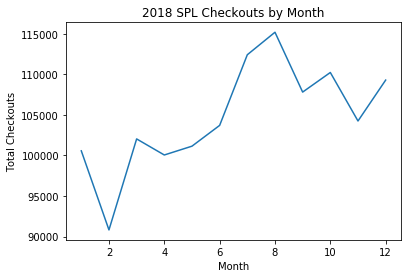

In [4]:
import seaborn as sns 
import matplotlib.pyplot as plt

index = pd.Series(range(0,13))

sns.lineplot(x=index, y=monthly_checkouts, data=df)
plt.xlabel('Month')
plt.ylabel('Total Checkouts')
plt.title('2018 SPL Checkouts by Month')
plt.show()

> Well, contrary to my hypothesis it looks like checkouts are  higher in the summer months. Makes sense, with kids out of school and families taking vacations. I will continue by testing how significant those differences are. 

> Now I'll define each season to follow with a t-test. It's important to note that for purposes of a t-test, it will calculate based on *checkouts per title*.

In [0]:
winter = df[(df['checkoutmonth'] == 1) | (df['checkoutmonth'] == 2) | (df['checkoutmonth'] == 12 )]
summer = df[(df['checkoutmonth'] == 6) | (df['checkoutmonth'] == 7) | (df['checkoutmonth'] == 8)]
spring = df[(df['checkoutmonth'] == 3) | (df['checkoutmonth'] == 4) | (df['checkoutmonth'] == 5)]
fall = df[(df['checkoutmonth'] == 9) | (df['checkoutmonth'] == 10) | (df['checkoutmonth'] == 11)]

The count below represents each unique title. Therefore the mean will be calculated by (sum of checkouts for summer months)/(count of titles for summer months) or (331,361)/(90,586)

In [6]:
from scipy import stats
import math

summer['checkouts'].describe()

count    90586.000000
mean         3.657971
std          8.024220
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        351.000000
Name: checkouts, dtype: float64

In [7]:
winter['checkouts'].describe()

count    85707.000000
mean         3.508395
std          8.045653
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        415.000000
Name: checkouts, dtype: float64

> So there's our stats for the summer and winter months. Time to test the significance.

In [8]:
stats.ttest_ind(winter['checkouts'], summer['checkouts'])

Ttest_indResult(statistic=-3.90677023960018, pvalue=9.357288784810133e-05)

> That's a low p-value! This means there is a true significant difference in the number of checkouts per title between the summer and winter seasons.
> Now I will calculate a confidence interval.

In [9]:
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("CI lower "+str(ci_lower)+" CI upper "+str(ci_upper))

get_95_ci(winter['checkouts'],summer['checkouts'])

'CI lower 0.07452947426087475 CI upper 0.22462362620388932'

> With 95% confidence, the difference in checkouts per title is between 0.075 and 0.225.

> I'm also curious to see what the most rented type of book is by the 'material type' category.


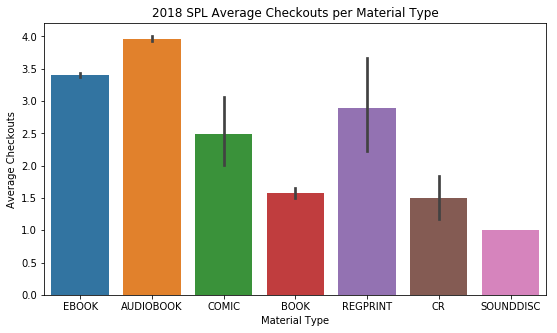

In [10]:
plt.figure(figsize = (9,5))
sns.barplot(x="materialtype", y="checkouts", data=df)
plt.xlabel('Material Type')
plt.ylabel('Average Checkouts')
plt.title('2018 SPL Average Checkouts per Material Type')
plt.show()

> Again, this is the average checkouts per title, separated by material type. Let's see the total number of checkouts per material for a better idea.

In [11]:
material_totals = df.groupby('materialtype')[['checkouts']].sum().sort_values(by='checkouts', ascending=False)
material_totals

,checkouts
materialtype,
EBOOK,831790
AUDIOBOOK,424297
BOOK,1101
COMIC,416
REGPRINT,26
CR,9
SOUNDDISC,2


> What were the top 10 titles checked out in 2018?

In [12]:
titles = df.groupby('title')[['checkouts']].sum().sort_values(by='checkouts', ascending=False)
titles.head(10)

,checkouts
title,
Little Fires Everywhere,3443
The Goldfinch: A Novel (Pulitzer Prize for Fiction),2792
Artemis: A Novel,2547
The Handmaid's Tale,2322
Today Will Be Different,2265
Origin: A Novel,2169
Into the Water: A Novel,1800
Manhattan Beach: A Novel,1789
All the Light We Cannot See: A Novel (unabridged) (Unabridged),1769


This analysis will be valuable for retailers, libraries and publishers. Retailers can get ahead of inventory and make merchandising decisions. Libraries can get ahead of checkout demand. Publishers will know the most effective time of year to release new titles. 

We also know that digital copies are in exponentially higher demand and libraries should keep susbstantial inventory. They may need to redistribute budget allocations for digital vs print. 